In [69]:
import pandas as pd
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import spacy
import re

retweeted=pd.read_csv('retweeted.csv')

In [81]:
#carichiamo il dizionario italiano esteso con spacy
nlp = spacy.load('it_core_news_lg') 

In [82]:
#lowercase
retweeted['text_preprocessed']=retweeted['text_complete'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [51]:
#applicazione per lemmatization con spacy
def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])


In [83]:
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

#pulizia da simboli
new_text=[]
for index,row in retweeted.iterrows():
    l1=[ t for t in row['text_preprocessed'].split() if t.startswith('#') ]
    l2=[ t for t in row['text_preprocessed'].split() if t.startswith('http') ]
    l3=[ t for t in row['text_preprocessed'].split() if t.startswith('@') ]
    stopword=l1+l2+l3
    querywords=row['text_preprocessed'].split()
    resultwords=[word for word in querywords if word.lower() not in stopword]
    result = ' '.join(resultwords)
    new_text.append(result)

retweeted['text_preprocessed']=new_text

#vengono cancellati tutti i termini che non sono alfanumerici o che non corrispondono a spazi vuoti
retweeted['text_preprocessed'] = retweeted['text_preprocessed'].str.replace('[^\w\s]',' ')

#viene applicata la lemmatization al testo, per essere processata dal modello di sentiment
retweeted['text_preprocessed']= retweeted['text_preprocessed'].apply(space)

C:\Users\Eric\AppData\Local\Temp/ipykernel_6588/2768048101.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  retweeted['text_preprocessed'] = retweeted['text_preprocessed'].str.replace('[^\w\s]',' ')


In [84]:
stop = stopwords.words('italian')

#rimozione caratteri speciali, stopwords, hyperlink, punteggiatura, utili per preparare il testo ai wordcloud
retweeted['text_preprocessed_new']=' '

for i in range(0,len(retweeted.text_preprocessed)):
    l1=[ t for t in retweeted['text_preprocessed'][i].split() if t.startswith('http') ]
    stopword=l1+stop
    querywords=retweeted['text_preprocessed'][i].split()
    resultwords=[word for word in querywords if word.lower() not in stopword]
    result = ' '.join(resultwords)
    result=result.replace('[^\w\s]','')
    result=result.translate ({ord(c): "" for c in "!@#$%^&*()[]{};:,./<>?\|`~-=_+"})
    retweeted['text_preprocessed_new'][i]=result


retweeted['text_preprocessed_new']= retweeted['text_preprocessed_new'].apply(space)



C:\Users\Eric\AppData\Local\Temp/ipykernel_6588/2496261292.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retweeted['text_preprocessed_new'][i]=result


In [ ]:
#preparazione del lexicon
sentix=pd.read_csv("sentix.csv", header=None,delimiter=';')

#riscaliamo i valori della sentiment come i precedenti valori del lexicon vader
#consideriamo valori estremi di vader lexicon -4 e +4
#consideriamo valori estremi di sentix lexicon -1 e +1

with open("sentix.txt",'w',encoding="utf-8") as txt_file:
    for index,line in sentix.iterrows():
        scaled_score=(((float(line[5]) + 1)/2)*(8))-4
        txt_file.write(str(line[0])+'\t'+str(scaled_score)+'\n')

#creo un dizionario per updatare il lexicon nltk di vader
d= dict([(parola,score) for parola, score in zip(sentix[0],sentix[5])])
sentix_dict=d


#arricchimento vader lexicon per multi-vader
with open('lexicon_vader_enriched.txt','w',encoding="utf-8") as newfile:
    with open('vader_lexicon.txt') as vader_file:
        for line in vader_file:
            newfile.write(line)
    with open('sentix.txt',encoding="utf-8") as sentix_file:
        for line in sentix_file:
            newfile.write(line)

In [109]:
#vader
from vaderSentiment import vaderSentiment

#non facciamo pulizia del testo sulle emojii
analyzer = vaderSentiment.SentimentIntensityAnalyzer(lexicon_file='lexicon_vader_enriched.txt',emoji_lexicon='emoji_utf8_lexicon.txt')

#il termine "positivo" è stato modificato associandolo a un sentiment negativo
#il termine "negativo" è associato a un sentiment neutro

In [ ]:
index_list=list(retweeted[retweeted.sentiment==0.0].index)

In [100]:
retweeted=retweeted.reset_index(drop=True)
retweeted['sentiment']=0.0

for index in index_list:
    if index > 337 :
        try:
            retweeted.at[index,'sentiment']=analyzer.polarity_scores(retweeted.loc[index,'text_preprocessed'])['compound']
        except Exception as e:
            print('exception handled, iteration reached: ',index)
            print('exception: ',e)
            break

exception handled, iteration reached:  428
exception:  HTTP Error 429: Too Many Requests


In [85]:
no_vax=retweeted[(retweeted.colours_y=='0') | (retweeted.colours_y=='2') ]['text_preprocessed_new']
pro_vax=retweeted[(retweeted.colours_y=='1') ]['text_preprocessed_new']

#creazione lista novax provax
listone_novax=' '.join(no_vax)
listone_provax=' '.join(pro_vax)


In [86]:
#creazione wordcloud con calibrazione dei parametri
wordcloud_novax = WordCloud(width = 2000, height = 1000, random_state=1, prefer_horizontal=1,
                              background_color='white', colormap='Set2', 
                              collocations=False,max_words=75,relative_scaling=0.5,
                              stopwords=['potere','essere','dovere','ogni','tre','poi','cè','me','qui','lamore','volere','fare','cosa','stare','l','e','mai','così','tutto','ciò','avere','molto','anno','tanto','quindi','grazia','dire','solo','andare','giorno','te','prendere','vaccinare','nn','gg','dm','dose','quando','già']).generate(listone_novax)

wordcloud_provax = WordCloud(width = 2000, height = 1000, random_state=1, prefer_horizontal=1,
                               background_color='white', colormap='Set2',
                               collocations=False,max_words=75,relative_scaling=.5,
                               stopwords=['potere','essere','dovere','ogni','tre','poi','cè','me','qui','lamore','volere','fare','cosa','stare','l','e','mai','così','tutto','ciò','avere','molto','anno','tanto','quindi','grazia','dire','solo','andare','giorno','te','prendere','vaccinare','nn','gg','dm','dose','quando','già']).generate(listone_provax)
import matplotlib.pyplot as plt
%matplotlib inline

def plot_cloud(wordcloud):
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud) 
    plt.axis("off")

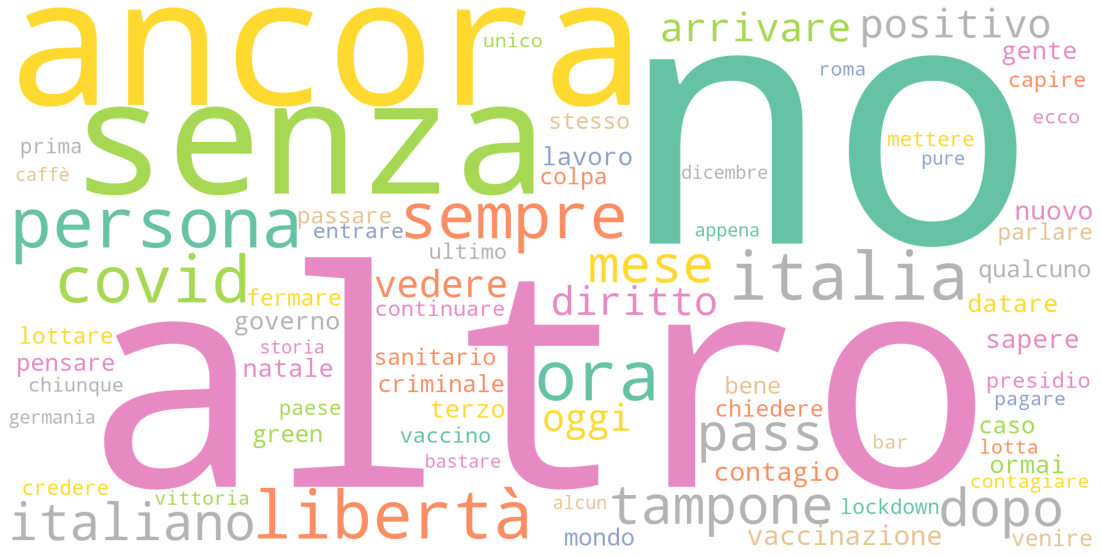

In [87]:
plot_cloud(wordcloud_novax)

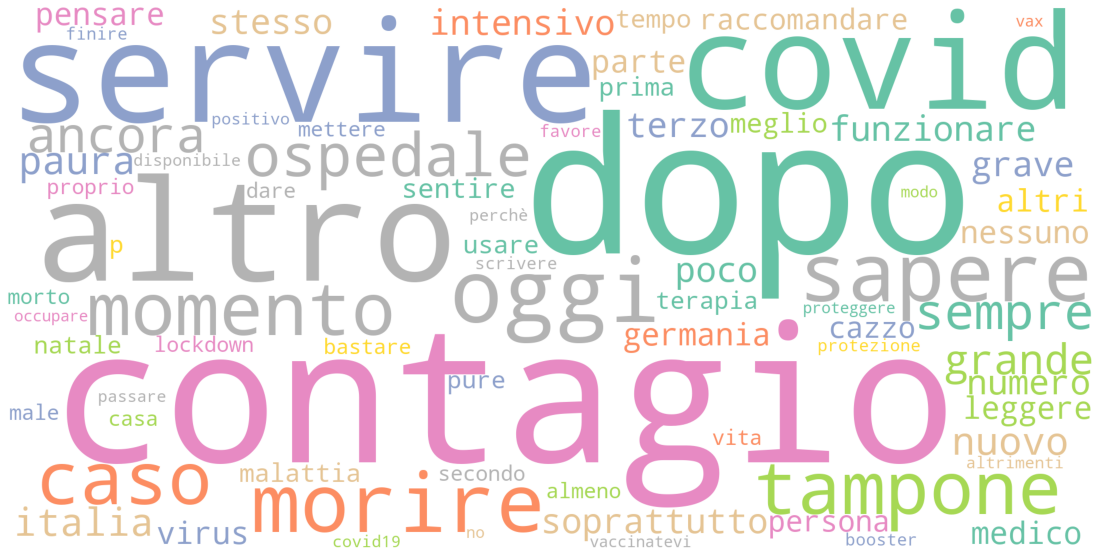

In [90]:
plot_cloud(wordcloud_provax)

In [5]:
mapping={'#007474':'pro_Vax', '#042069':'no_Vax', '#99cccc':'no_Vax', '#b00b69':'pro_Vax', '#fb1239':'no_Vax'}

In [6]:
retweeted_plt=retweeted.replace({'Colour':mapping})

<AxesSubplot:xlabel='Colour', ylabel='sentiment'>

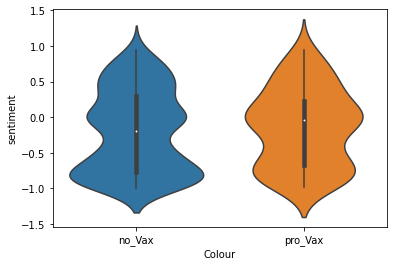

In [7]:
import seaborn as sns

sns.violinplot(x='Colour',y='sentiment',data=retweeted_plt)

In [108]:
max(retweeted_plt[retweeted_plt.Colour=='no_Vax']['sentiment'])

0.9366

In [93]:
min(retweeted_plt[retweeted_plt.Colour=='no_Vax']['sentiment'])

-0.9898

In [12]:
list(retweeted_plt[retweeted_plt.sentiment==max(list(retweeted_plt.sentiment))]['text_complete'])

['@roberto2_lamela #Poverementi #novax,il vaccino protegge non facendo miracolosam. sparire il virus,ma rinforzando le difese immunitarie in modo mirato,ti puoi infettare,ma hai già dentro di te buone armi per combatterlo e non ammalarti.\n+vaccinati= -terreno fertile per il virus.\n#vaccinatevi ✌️']

In [28]:
retweeted_plt[retweeted_plt.sentiment==max(list(retweeted_plt.sentiment))]['author_id']

433    988846494
Name: author_id, dtype: int64

In [13]:
list(retweeted_plt[retweeted_plt.sentiment==min(list(retweeted_plt.sentiment))]['text_complete'])

["Ma come c@zzo è possibile soltanto pensare che una persona possa morire dopo aver fatto un' iniezione e dire che hai un sospetto. È una certezza, chiaro?! \n#NoGreenPass #NoDittatura #giulemanidaibambini #governodeipeggiori https://t.co/47vbtTs9rs"]